In [423]:
from fastai.vision.all import *
from fastbook import *
from torch.utils.data import TensorDataset, DataLoader

In [424]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [425]:
csvFile = pd.read_csv('.data/Iris.csv')
print(csvFile.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


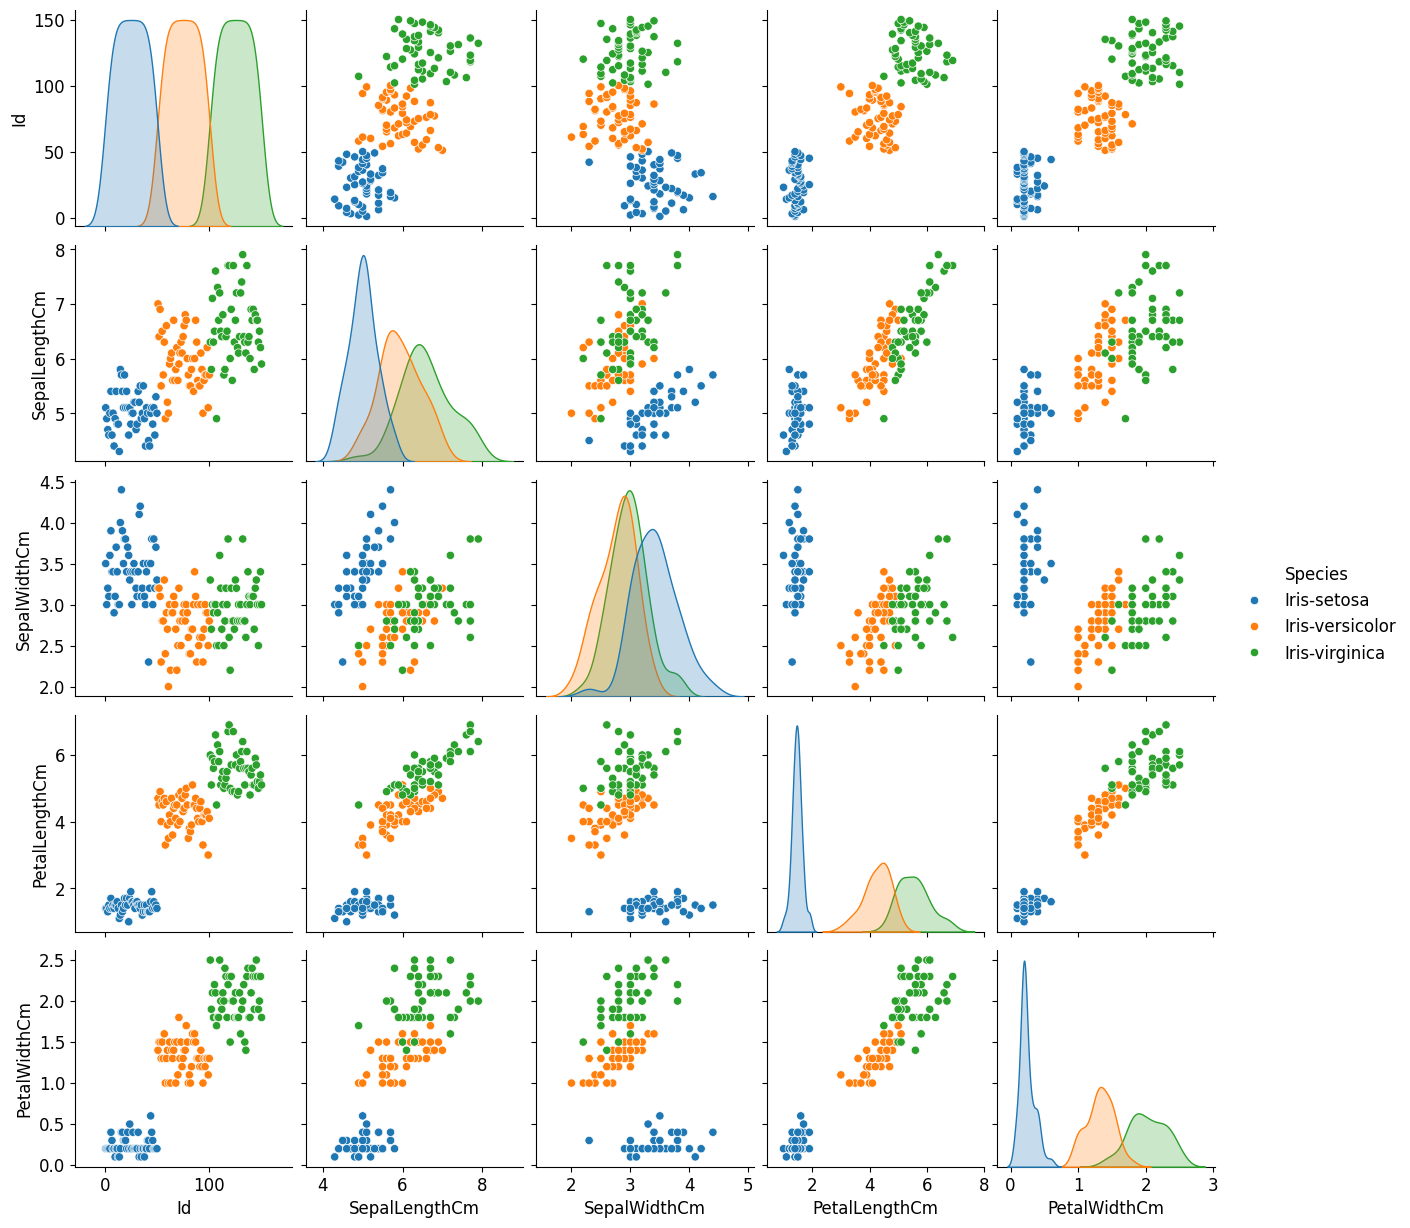

In [426]:
sns.pairplot(csvFile, hue="Species")
plt.show()

In [427]:
species_counts = csvFile['Species'].value_counts()
species_counts

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

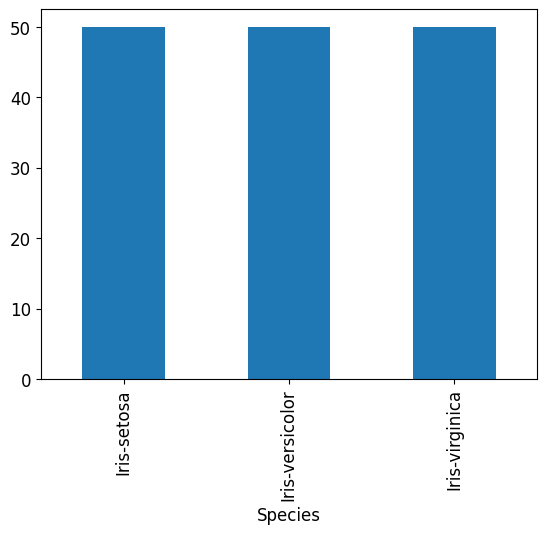

In [428]:
species_counts.plot(kind='bar')
plt.show()

In [429]:
csvFile['Species'] = pd.Categorical(csvFile['Species']).codes
csvFile

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [430]:
x = torch.tensor(csvFile.drop(columns=['Species', 'Id']).values, dtype=torch.float32)
y = torch.tensor(csvFile['Species'].values, dtype=torch.long)
x, y

(tensor([[5.1000, 3.5000, 1.4000, 0.2000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [4.7000, 3.2000, 1.3000, 0.2000],
         [4.6000, 3.1000, 1.5000, 0.2000],
         [5.0000, 3.6000, 1.4000, 0.2000],
         [5.4000, 3.9000, 1.7000, 0.4000],
         [4.6000, 3.4000, 1.4000, 0.3000],
         [5.0000, 3.4000, 1.5000, 0.2000],
         [4.4000, 2.9000, 1.4000, 0.2000],
         [4.9000, 3.1000, 1.5000, 0.1000],
         [5.4000, 3.7000, 1.5000, 0.2000],
         [4.8000, 3.4000, 1.6000, 0.2000],
         [4.8000, 3.0000, 1.4000, 0.1000],
         [4.3000, 3.0000, 1.1000, 0.1000],
         [5.8000, 4.0000, 1.2000, 0.2000],
         [5.7000, 4.4000, 1.5000, 0.4000],
         [5.4000, 3.9000, 1.3000, 0.4000],
         [5.1000, 3.5000, 1.4000, 0.3000],
         [5.7000, 3.8000, 1.7000, 0.3000],
         [5.1000, 3.8000, 1.5000, 0.3000],
         [5.4000, 3.4000, 1.7000, 0.2000],
         [5.1000, 3.7000, 1.5000, 0.4000],
         [4.6000, 3.6000, 1.0000, 0.2000],
         [5

In [431]:
from sklearn.model_selection import train_test_split

In [432]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [433]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([120, 4]),
 torch.Size([30, 4]),
 torch.Size([120]),
 torch.Size([30]))

In [434]:
lr = 1.

In [435]:
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_val dtype: {X_val.dtype}")
print(f"y_val dtype: {y_val.dtype}")

X_train dtype: torch.float32
y_train dtype: torch.int64
X_val dtype: torch.float32
y_val dtype: torch.int64


In [436]:
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=6, shuffle=True)
valid_dl = DataLoader(TensorDataset(X_val, y_val), batch_size=6, shuffle=True)
dls = DataLoaders(train_dl, valid_dl)

In [437]:
simple_net = nn.Sequential(
    nn.Linear(4,120),
    nn.ReLU(),
    nn.Linear(120,3)
)

In [438]:
loss_func = nn.CrossEntropyLoss()

In [439]:
def batch_accuracy(preds, targets):
    _, preds_max = preds.max(1)
    return (preds_max == targets).float().mean()

In [440]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=loss_func, metrics=batch_accuracy)
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,1.744703,0.638648,0.700000,00:00
1,0.942541,0.297742,1.000000,00:00
2,0.720728,0.262641,0.900000,00:00
3,0.545125,0.199314,1.000000,00:00
4,0.501493,0.276595,0.800000,00:00
5,0.396779,0.166224,1.000000,00:00
6,0.342972,0.153799,0.966667,00:00
7,0.357778,0.265683,0.966667,00:00
8,0.327791,0.232586,0.866667,00:00
9,0.325496,0.243771,0.833333,00:00


In [441]:
sample_idx = 0
sample = X_val[sample_idx]
sample = sample.unsqueeze(0)  # Reshape to [1, num_features]

print(sample)

preds, _ = learn.get_preds(dl=DataLoader(TensorDataset(sample), batch_size=1))

predicted_class = preds.argmax(dim=1).item()

class_names = csvFile['Species'].astype('category').cat.categories.tolist()
print(f"Predicted class: {class_names[predicted_class]}")

probabilities = preds.softmax(dim=1).squeeze().tolist()
print("Probabilities for each class:")
for name, prob in zip(class_names, probabilities):
    print(f"{name}: {prob:.4f}")

print(f"\ncorrect: {y_val[sample_idx]}")


tensor([[6.1000, 2.8000, 4.7000, 1.2000]])


Predicted class: 2
Probabilities for each class:
0: 0.0042
1: 0.4707
2: 0.5250

correct: 1
